In [2]:
import sys, os
import json, pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import time as pytime
import statsmodels.tsa.stattools as tsa
import ruptures as rpt
import InsanallyLabEphysTools as ilep
from scipy.stats import gaussian_kde, sem, ttest_ind, ttest_rel, norm, mannwhitneyu, linregress, wilcoxon
from tqdm import tqdm
from types import SimpleNamespace
from sklearn import linear_model

plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['axes.formatter.limits'] = [-2,3]
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['figure.dpi'] = '150'

#Set global font parameters
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
#Set font type to TrueType for compatibility
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

CR_COLOR = '#808080'
NCR_COLOR = '#FF767C'
CNO_COLOR = '#00BFFF'

In [3]:
starttime = pytime.time()

if False:
    #Trim Sessions
    ilep.trimSessions('S:\\Sorts\DualRecording',replace=False)
    endtime1 = pytime.time()
    #Calculate Responsiveness
    ilep.calculateResponsiveness('S:\\Sorts\DualRecording',replace=True)
    endtime2 = pytime.time()
    #Finish
    ilep.loadSessionsComplete('S:\\Sorts\DualRecording',verbose=False)
    endtime3 = pytime.time()
    print('Trimming       : ' + str((endtime1-starttime)/60)+' minutes elapsed');
    print('Responsiveness : ' + str((endtime2-starttime)/60)+' minutes elapsed');
    print('Finished       : ' + str((endtime3-starttime)/60)+' minutes elapsed');

0.0 hours elapsed


In [6]:
directory = 'D:\\Analysis_Cache'

numbersessions = 0
numberdisqlen = 0
numberdisqISI = 0
numberdisqFR = 0
numAC = 0
numM2 = 0
numTrim = 0

sessions = os.listdir(directory)
for session in sessions:
    sessionfile = ilep.loadSessionCached(directory,session)
    numbersessions += 1
    numberdisqlen += len(sessionfile.disqualified.NumTrials)
    numberdisqISI += len(sessionfile.disqualified.ISI)
    numberdisqFR += len(sessionfile.disqualified.FRthresh)

    if sessionfile.meta.region == 'AC':
        numAC += len(sessionfile.clusters.good)
    elif sessionfile.meta.region == 'M2':
        numM2 += len(sessionfile.clusters.good)
    else:
        pass
    
    if hasattr(sessionfile,'trim'):
        numTrim += 1

print(str(numbersessions)+' sessions')
print('AC       : ' + str(numAC))
print('M2       : ' + str(numM2))
print('Trim     : ' + str(numTrim))
print('Disq Len : ' + str(numberdisqlen))
print('Disq ISI : ' + str(numberdisqISI))
print('Disq FR  : ' + str(numberdisqFR))
print(sessionfile.meta)

344 sessions
AC       : 2170
M2       : 2688
Trim     : 344
Disq Len : 544
Disq ISI : 33
Disq FR  : 74
namespace(ISI_threshold_ms=1, animal='BS_95', arraystart=0, behavior='naive', condition='postreversal naive', date='3/1/2022', day_of_recording=6, day_of_reversal=3, day_of_training=11, depth=817, directory='D:\\DualRecording\\BS_95\\BS_95 6\\M2\\', files=['March 1 2022 Dual BS_95_6001', 'March 1 2022 Dual BS_95_6002', 'March 1 2022 Dual BS_95_6003'], fs=30000, length_in_minutes=18.683240555555553, length_in_samples=33629833.0, length_in_seconds=1120.9944333333333, length_in_trials=332, probe=8946, region='M2', task='reversal', tonelength=0.1, triallength=2.5)


In [ ]:
for session in sessions:
    sessionfile = ilep.loadSessionCached(destination,session)
    
    for clust in sessionfile.clusters.good:
        breakpoints,xrange,signal = calculateSegments(sessionfile,clust,scaling=1/1000)
        breakpoints = np.array(breakpoints)
        breakpoints = np.concatenate(([0],breakpoints,[int(sessionfile.meta.length_in_seconds)]))
        breakpoints = np.sort(np.unique(breakpoints))
        bins = [ [breakpoints[idx],breakpoints[idx+1]] for idx in range(len(breakpoints)-1)]

In [27]:
### SEPARATED BY GO/NOGO OR TARGET/NONTARGET

def binData(datatobin,binsize = 10,smoothing = 0):
    bins = np.zeros(len(datatobin))

    for bin in range(len(bins)):
        try:
            s = binsize*bin
            e = (binsize+binsize*bin)
            bins[bin] = np.mean(np.array(datatobin)[s:e])
        except Exception as e:
            print( e)
    bins = np.array(bins)
    bins = bins[np.logical_not(np.isnan(bins))]
    
    tempbins = bins
    for idx in range(len(bins)):
        temp = [np.nan,bins[idx],bins[idx],np.nan]
        if idx > 0:
            temp[0] = bins[idx-1]
        if idx < len(bins)-1:
            temp[3] = bins[idx+1]
        tempbins[idx] = np.nanmean(temp)
    bins = tempbins
    
    return bins

def binKDE(sessionfile,clust,bw = 0.05):
    spikeidxs = np.equal(sessionfile.spikes.clusters,clust)
    spiketimes = sessionfile.spikes.times[spikeidxs]

    numentries = int(sessionfile.meta.length_in_seconds)
    xrange = np.linspace(0,sessionfile.meta.length_in_samples,numentries)
    KDE = gaussian_kde(np.concatenate(spiketimes),bw_method=bw).evaluate(xrange)
    return xrange,KDE

def calculateRunningSTDEV(binnedData,bw=5):
    stdevs = []
    for idx in range(len(binnedData)-bw):
        if(np.mean(binnedData[idx:idx+bw])) > 0:
            stdevs.append(np.std(binnedData[idx:idx+bw]))
    return np.median(stdevs)

def calculateSegments(sessionfile,clust,scaling = 1):
    #bins = binData(datatobin)
    #sigma = calculateRunningSTDEV(bins)
    
    xrange,signal = binKDE(sessionfile,clust)
    sigma = calculateRunningSTDEV(signal,bw=60)
    
    model = "l2"  # "l1", "rbf", "linear", "normal", "ar",...
    algo = rpt.Binseg(model=model).fit(signal)
    #algo = rpt.BottomUp(model=model).fit(bins)
    #algo = rpt.Window(width=5, model=model).fit(bins)
    #my_bkps = algo.predict(pen=np.log(len(bins)) * 1 * 5**2)
    my_bkps = algo.predict(pen= np.log(len(signal)) * sigma**2 / scaling)
    #breakpoints is in seconds
    return my_bkps,xrange,signal

def getTrialOfTime(sessionfile,timeInSeconds):
    time = timeInSeconds * sessionfile.meta.fs
    for trial in range(sessionfile.meta.length_in_trials):
        if sessionfile.trials.starts[trial] < time and sessionfile.trials.ends[trial] > time:
            return trial+1
    
    for trial in range(sessionfile.meta.length_in_trials - 1):
        if sessionfile.trials.ends[trial] < time and sessionfile.trials.starts[trial+1] > time:
            return trial+1.5
    
    if time < min(sessionfile.trials.starts):
        return 1
    if time > max(sessionfile.trials.ends):
        return sessionfile.meta.length_in_trials
    
    return np.nan

starttime = -0.7
endtime = 2.7
numbins = 100 + 1

height=10
width=1
trans=0.125
custommarker = mpl.path.Path([[-width,-height],[-width,height],[width,height],[width,-height]],closed=True)
    
for session in tqdm(sessions):
    break
    try:
        sessionfile = ilep.loadSessionCached(destination,session)
        neurons = sessionfile.clusters.good
        
        ##########################################################################################################################
        #laserON = sessionfile.trials.laser_stimulation
        #laserOFF = np.logical_not(laserON)
        All = np.full((sessionfile.meta.length_in_trials), True)
        GoResponse = sessionfile.trials.go
        NogoResponse = np.logical_not(GoResponse)
        TargetTone = sessionfile.trials.target
        NontargetTone = np.logical_not(TargetTone)
        
        Hits = np.logical_and(TargetTone,GoResponse)
        Misses = np.logical_and(TargetTone,NogoResponse)
        FAlarms = np.logical_and(NontargetTone,GoResponse)
        CRejects = np.logical_and(NontargetTone,NogoResponse)
        Correct = np.logical_or(Hits,CRejects)
        Incorrect = np.logical_or(Misses,FAlarms)
        
        #Condition A
        conditionA = SimpleNamespace()
        conditionA.trials = All
        conditionA.label = 'All'
        conditionA.color = 'grey'

        conditions = [conditionA]
        #Convert trials into idxs -- more useful for algorithm
        for cond in conditions:
            cond.trials = np.array(np.where(cond.trials)[0])
        ##########################################################################################################################
        totaltrials = 0
        for cond in conditions:
            totaltrials += len(cond.trials)
        
        for clust in neurons:
            plt.close('all')
            fig = plt.figure(figsize=(12.5,12.5))
            gs = fig.add_gridspec(3,2,height_ratios=[4,1,1],hspace=0.2,wspace=0.5)#0.1)
                
            ax1 = plt.subplot(gs[0,0])#Raster
            ax2 = plt.subplot(gs[1,0],sharex=ax1)#PSTH
            ax3 = plt.subplot(gs[0,1])#FRs
            ax4 = plt.subplot(gs[1,1])#,sharex=ax1,sharey=ax2)#Percent Go
            
            #Caching search -- Unit
            idx = np.equal(sessionfile.spikes.clusters,clust)
            totaltimes = sessionfile.spikes.times[idx]
            
            FRpertrial = []
            #Overall Nonstationarity
            for trial in range(sessionfile.meta.length_in_trials):
                trialstart = sessionfile.trials.starts[trial]
                trialend = sessionfile.trials.ends[trial]
                idxtone = np.logical_and(   np.greater(totaltimes,trialstart) , np.less(totaltimes,trialend)  )
                timestone = totaltimes[idxtone]
                trialtime = (trialend-trialstart) / sessionfile.meta.fs
                FRpertrial.append(len(timestone) / trialtime)
            
            for cond in conditions:         
                cond.latency = []
                cond.firingrates = []
                cond.timestoplot = []
                cond.trialstoplot = []
                cond.responsetimestoplot = []
                cond.responsetrialstoplot = []
                cond.peristimulustimes = []
                cond.onsetmodulation = np.nan
                cond.offsetmodulation = np.nan
                cond.pc = np.nan
                cond.dp = np.nan
                
                cond.firingbins100 = []
                cond.firingbins200 = []
                
                pretonebin1 = []
                pretonebin2 = []
                tonebin = []
                posttonebin = []
                
                #Calculate Behavior Stats
                temparray = np.zeros(sessionfile.meta.length_in_trials)
                temparray[cond.trials] = np.ones(len(cond.trials))
                condhits = np.sum(np.logical_and(temparray,Hits))
                condmisses = np.sum(np.logical_and(temparray,Misses))
                condfalarms = np.sum(np.logical_and(temparray,FAlarms))
                condcrejects = np.sum(np.logical_and(temparray,CRejects))
                
                try:
                    cond.pc = (condhits+condmisses) / (condhits+condmisses+condfalarms+condcrejects)
                except Exception:
                    pass
                try:
                    cond.dp = norm.ppf((condhits+1)/(condhits+condmisses+2)) - norm.ppf((condfalarms+1)/(condfalarms+condcrejects+2))
                except Exception:
                    pass
                
                for trialidx in range(len(cond.trials)):
                    trial = cond.trials[trialidx]
                    trialstart = sessionfile.trials.starts[trial]
                    
                    #Caching search -- Condition
                    idx = np.logical_and(      np.greater(totaltimes,trialstart+starttime*sessionfile.meta.fs) , np.less(totaltimes,trialstart+endtime*sessionfile.meta.fs)     )
                    times = totaltimes[idx]
                    
                    #PSTH times
                    cond.peristimulustimes = np.concatenate((cond.peristimulustimes,(times-trialstart)/sessionfile.meta.fs*1000))
                    
                    #Response times
                    if (sessionfile.trials.go[trial]):
                        cond.responsetimestoplot.append((sessionfile.trials.response[trial]-trialstart)/sessionfile.meta.fs*1000)
                        cond.responsetrialstoplot.append(trialidx+1)
                    
                    #Each spike time to plot
                    for spike in ((times-trialstart)/sessionfile.meta.fs*1000):
                        cond.timestoplot.append(spike)
                        cond.trialstoplot.append(trialidx+1)
                    
                    #Caching search -- Pre-tone period (1)
                    binstart = trialstart-0.2*sessionfile.meta.fs
                    binend = trialstart-0.1*sessionfile.meta.fs
                    idxtone = np.logical_and(   np.greater(totaltimes,binstart) , np.less(totaltimes,binend)  )
                    timestone = totaltimes[idxtone]
                    pretonebin1.append(len(timestone))
                    
                    #Caching search -- Pre-tone period (2)
                    binstart = trialstart-0.1*sessionfile.meta.fs
                    binend = trialstart+0*sessionfile.meta.fs
                    idxtone = np.logical_and(   np.greater(totaltimes,binstart) , np.less(totaltimes,binend)  )
                    timestone = totaltimes[idxtone]
                    pretonebin2.append(len(timestone))
                    
                    #Caching search -- Tone Period
                    binstart = trialstart+0*sessionfile.meta.fs
                    binend = trialstart+0.1*sessionfile.meta.fs
                    idxtone = np.logical_and(   np.greater(totaltimes,binstart) , np.less(totaltimes,binend)  )
                    timestone = totaltimes[idxtone]
                    tonebin.append(len(timestone))
                    cond.firingbins100.append(len(timestone))
                    tempvar = (len(timestone))
                    #Latency and firing rate
                    if len(timestone)>0:
                        cond.latency.append( (np.min(timestone)-trialstart)/sessionfile.meta.fs*1000)
                    else:
                        cond.latency.append(np.nan)
                    cond.firingrates.append(len(timestone) / (0.1))
                    
                    #Caching search -- Post-tone period
                    binstart = trialstart+0.1*sessionfile.meta.fs
                    binend = trialstart+0.2*sessionfile.meta.fs
                    idxtone = np.logical_and(   np.greater(totaltimes,binstart) , np.less(totaltimes,binend)  )
                    timestone = totaltimes[idxtone]
                    posttonebin.append(len(timestone))
                    cond.firingbins200.append(len(timestone)+tempvar)
                    
                    #Calculate bootstrapped firing rate modulation
                    pretonebins = np.concatenate((pretonebin1,pretonebin2))
                    numtrials = len(tonebin)
                    FRmodonset = []
                    FRmodoffset = []
                    for sample in range(100):
                        baseline = np.mean(np.random.choice(pretonebins,size=int(0.9*numtrials),replace=True))
                        if baseline == 0:
                            baseline = 0.01
                        onset = np.mean(np.random.choice(tonebin,size=int(0.9*numtrials),replace=True))
                        offset = np.mean(np.random.choice(posttonebin,size=int(0.9*numtrials),replace=True))
                        FRmodonset.append((onset-baseline))
                        FRmodoffset.append((offset-baseline))
                    cond.onsetmodulation = np.mean(FRmodonset)*10 #Scaling factor from 100ms bin to firing rate (1s)
                    cond.offsetmodulation = np.mean(FRmodoffset)*10
            #NOTE HERE            
                        
            #############################################---TRIMMING---#############################################
                
            FRthreshold = 0.5 #S/s
                
            #Calculate breakpoints with Binary Segmentation
            #breakpoints = np.array(calculateSegments(FRpertrial,scaling=0.05))*10
            #breakpoints = np.concatenate(([0],breakpoints,[sessionfile.meta.length_in_trials]))
            #breakpoints = np.sort(np.unique(breakpoints))
            #bins = [ [breakpoints[idx],breakpoints[idx+1]] for idx in range(len(breakpoints)-1)]
            
            breakpoints,xrange,signal = calculateSegments(sessionfile,clust,scaling=1/1000)
            breakpoints = np.array(breakpoints)
            breakpoints = np.concatenate(([0],breakpoints,[int(sessionfile.meta.length_in_seconds)]))
            breakpoints = np.sort(np.unique(breakpoints))
            bins = [ [breakpoints[idx],breakpoints[idx+1]] for idx in range(len(breakpoints)-1)]
            
            validbins = np.zeros(len(bins))
            validbins.fill(True)
            #Scan list from start to end
            for binidx in range(len(bins)):
                bin = bins[binidx]
                idx = np.logical_and(      np.greater(totaltimes,bin[0]*sessionfile.meta.fs) , np.less(totaltimes,bin[1]*sessionfile.meta.fs)     )
                binFR = np.sum(idx) / (binend-binstart)
                
                if binFR < FRthreshold:
                    validbins[binidx] = isbinvalid
                else:
                    break
                
            for binidx,bin in enumerate(bins):
                idx = np.logical_and(      np.greater(totaltimes,bin[0]*sessionfile.meta.fs) , np.less(totaltimes,bin[1]*sessionfile.meta.fs)     )
                binFR = np.sum(idx) / (binend-binstart)
                
                if binFR < FRthreshold:
                    validbins[binidx] = isbinvalid
                else:
                    break
                    
            for binidx,bin in reversed(list(enumerate(bins))):
                idx = np.logical_and(      np.greater(totaltimes,bin[0]*sessionfile.meta.fs) , np.less(totaltimes,bin[1]*sessionfile.meta.fs)     )
                binFR = np.sum(idx) / (binend-binstart)
                
                if binFR < FRthreshold:
                    validbins[binidx] = isbinvalid
                else:
                    break
            
                
            #############################################---PLOTTING---#############################################
                
            #Plot Rasters
            #ylims1 = [1,totaltrials]
            offset = 0
            tickmeans = []
            ticklabels = []
            numtrials = 0
            for cond in [conditions[0]]:
                ax1.scatter(cond.timestoplot,np.array(cond.trialstoplot)+offset,s=7.5,c=cond.color,marker=custommarker.vertices)
                #ax1.scatter(cond.responsetimestoplot,np.array(cond.responsetrialstoplot)+offset,s=7.5,c='black')
                tickmeans.append(0.5*len(cond.trials)+offset)
                #ax1.fill_between([starttime*1000,endtime*1000],[offset,offset],[offset+len(cond.trials),offset+len(cond.trials)],fc=cond.color,alpha=trans,zorder=-10)
                offset += len(cond.trials)
                ticklabels.append(cond.label+'\n Onset: '+str(np.round(cond.onsetmodulation,2))+'\n Offset: '+str(np.round(cond.offsetmodulation,2)))
                numtrials += len(cond.trials)
            xlims = ax1.get_xlim()
            for bp in breakpoints:
                bkp = getTrialOfTime(sessionfile,bp)
                ax1.plot(xlims,[bkp,bkp],color='blue',lw=2,zorder=10)
            for binidx in range(len(bins)):
                bin = bins[binidx]
                binstart = getTrialOfTime(sessionfile,bin[0])
                binend = getTrialOfTime(sessionfile,bin[1])
                validbin = validbins[binidx]
                
                if validbin:
                    ax1.fill_between(xlims,[binstart,binstart],[binend,binend],alpha=trans,color='green',zorder=9)
                else:
                    ax1.fill_between(xlims,[binstart,binstart],[binend,binend],alpha=trans,color='red',zorder=9)
            ax1.set_xlim(xlims)
            ylims1 = [1,numtrials]
            #Label Conditions
            #ticks = [1, np.round(len(trialidxs)/20)*10 ,len(trialidxs)]
            ax1.set_ylim(ylims1)
            #ax1.set_yticks(tickmeans,minor=False)
            #ax1.set_yticklabels(ticklabels,rotation=45)
            #Plot Tone/Laser
            ax1.fill_between([0,100],[ylims1[1],ylims1[1]],color='grey',alpha=trans)
            ax1.set_ylabel('Trial')
            
            #Plot PSTHs
            bw=0.05
            xrangePSTH = np.linspace(starttime*1000,endtime*1000-starttime*1000,num=1000)
            ind = 0
            for cond in [conditions[0]]:
                try:
                    KDE = gaussian_kde((cond.peristimulustimes),bw_method=bw).evaluate(xrangePSTH)
                    targetmean = len(cond.peristimulustimes) / (endtime-starttime) / len(cond.trials)
                    #if(sigs[ind]):
                    ax2.plot(xrangePSTH,targetmean*KDE/np.mean(KDE),c=cond.color,lw=2)
                    #else:
                    #    ax2.plot(xrange,targetmean*KDE/np.mean(KDE),c=cond.color,lw=2,alpha=0.25)
                except Exception as e:
                    print('PSTHs: '+str(e))
                ind = ind + 1
            
            #Plot KDE
            ax3.plot(signal,xrange,color='black',lw=2)
            xlims = ax3.get_xlim()
            for bp in breakpoints:
                bp = xrange[bp-1]
                print('bp: '+str(bp))
                print(xrange)
                ax3.plot(xlims,[bp,bp],color='blue',lw=2,zorder=10)
            ax3.set_xlim(xlims)
            ax3.set_xticks([])
            ax3.set_xlabel('Firing rate KDE')
            ax3.set_ylabel('Time (samples)')
            
            #Plot FR over time
            for cond in [conditions[0]]:
                ax4.plot(cond.firingrates,color='black')
                ax4.set_ylabel('Firing rate (S/s)')
                ax4.set_xlabel('Trial')
            ylims = ax4.get_ylim()
            for bp in breakpoints:
                bkp = getTrialOfTime(sessionfile,bp)
                ax4.plot([bkp,bkp],ylims,color='blue',lw=2)
            ax4.set_ylim(ylims)
            for binidx in range(len(bins)):
                bin = bins[binidx]
                binstart = getTrialOfTime(sessionfile,bin[0])
                binend = getTrialOfTime(sessionfile,bin[1])
                validbin = validbins[binidx]
                
                if validbin:
                    ax4.fill_between([binstart,binend],[ylims[0],ylims[0]],[ylims[1],ylims[1]],alpha=trans,color='green',zorder=9)
                else:
                    ax4.fill_between([binstart,binend],[ylims[0],ylims[0]],[ylims[1],ylims[1]],alpha=trans,color='red',zorder=9)

            ylims2 = ax2.get_ylim()
            ax2.fill_between([0,100],[ylims2[1],ylims2[1]],color='grey',alpha=trans)
            ax2.set_ylabel('Spikes per second')
            ax2.set_xlabel('Time (ms)')
            
            #ylims4 = ax4.get_ylim()
            #ax4.fill_between([0,100],[ylims4[1],ylims4[1]],color='grey',alpha=trans)
            #ax4.set_ylabel('Spikes per second')
            #ax4.set_xlabel('Time (ms)')
            
            ax1.set_xlim([-500,2500])
            
            fig.savefig(os.path.join('D:\\\\TempFigures','Stationarity3',session + ' cluster ' + str(clust) + ' TargNontarg.png'),transparent=False,facecolor="white")
    except Exception as e:
        print(e)

  0%|          | 0/344 [00:00<?, ?it/s]


  0%|          | 0/344 [00:00<?, ?it/s]C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\insan\anaconda3\envs\EphysPlotti

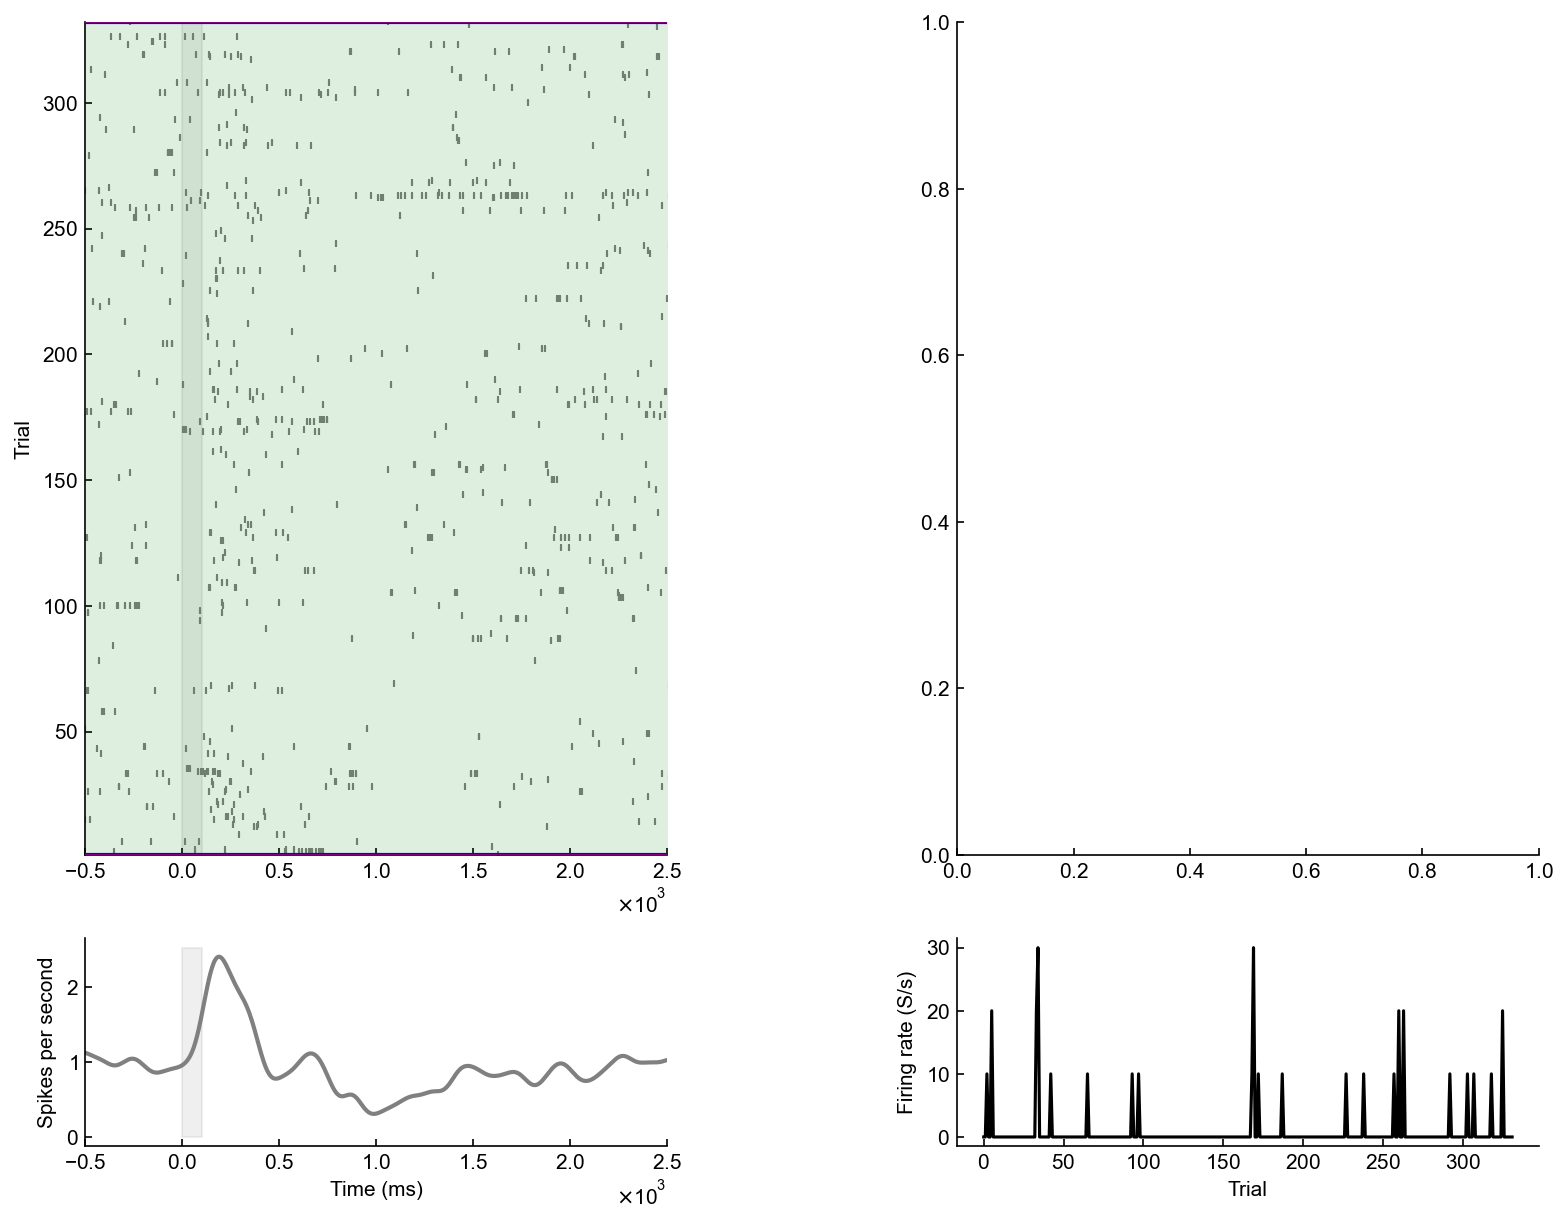

In [7]:
### SEPARATED BY GO/NOGO OR TARGET/NONTARGET

def getTrialOfTime(sessionfile,timeInSeconds):
    time = timeInSeconds * sessionfile.meta.fs
    for trial in range(sessionfile.meta.length_in_trials):
        if sessionfile.trials.starts[trial] < time and sessionfile.trials.ends[trial] > time:
            return trial+1
    
    for trial in range(sessionfile.meta.length_in_trials - 1):
        if sessionfile.trials.ends[trial] < time and sessionfile.trials.starts[trial+1] > time:
            return trial+1.5
    
    if time < min(sessionfile.trials.starts):
        return 1
    if time > max(sessionfile.trials.ends):
        return sessionfile.meta.length_in_trials
    
    return np.nan

starttime = -0.7
endtime = 2.7
numbins = 100 + 1

height=10
width=1
trans=0.125
custommarker = mpl.path.Path([[-width,-height],[-width,height],[width,height],[width,-height]],closed=True)
    
for session in tqdm(sessions):
    try:
        sessionfile = ilep.loadSessionCached(destination,session)
        neurons = sessionfile.clusters.good
        
        ##########################################################################################################################
        #laserON = sessionfile.trials.laser_stimulation
        #laserOFF = np.logical_not(laserON)
        All = np.full((sessionfile.meta.length_in_trials), True)
        GoResponse = sessionfile.trials.go
        NogoResponse = np.logical_not(GoResponse)
        TargetTone = sessionfile.trials.target
        NontargetTone = np.logical_not(TargetTone)
        
        Hits = np.logical_and(TargetTone,GoResponse)
        Misses = np.logical_and(TargetTone,NogoResponse)
        FAlarms = np.logical_and(NontargetTone,GoResponse)
        CRejects = np.logical_and(NontargetTone,NogoResponse)
        Correct = np.logical_or(Hits,CRejects)
        Incorrect = np.logical_or(Misses,FAlarms)
        
        #Condition A
        conditionA = SimpleNamespace()
        conditionA.trials = All
        conditionA.label = 'All'
        conditionA.color = 'grey'

        conditions = [conditionA]
        #Convert trials into idxs -- more useful for algorithm
        for cond in conditions:
            cond.trials = np.array(np.where(cond.trials)[0])
        ##########################################################################################################################
        totaltrials = 0
        for cond in conditions:
            totaltrials += len(cond.trials)
        
        for clust in neurons:
            plt.close('all')
            fig = plt.figure(figsize=(12.5,12.5))
            gs = fig.add_gridspec(3,2,height_ratios=[4,1,1],hspace=0.2,wspace=0.5)#0.1)
                
            ax1 = plt.subplot(gs[0,0])#Raster
            ax2 = plt.subplot(gs[1,0],sharex=ax1)#PSTH
            ax3 = plt.subplot(gs[0,1])#FRs
            ax4 = plt.subplot(gs[1,1])#,sharex=ax1,sharey=ax2)#Percent Go
            
            #Caching search -- Unit
            idx = np.equal(sessionfile.spikes.clusters,clust)
            totaltimes = sessionfile.spikes.times[idx]
            
            FRpertrial = []
            #Overall Nonstationarity
            for trial in range(sessionfile.meta.length_in_trials):
                trialstart = sessionfile.trials.starts[trial]
                trialend = sessionfile.trials.ends[trial]
                idxtone = np.logical_and(   np.greater(totaltimes,trialstart) , np.less(totaltimes,trialend)  )
                timestone = totaltimes[idxtone]
                trialtime = (trialend-trialstart) / sessionfile.meta.fs
                FRpertrial.append(len(timestone) / trialtime)
            
            for cond in conditions:         
                cond.latency = []
                cond.firingrates = []
                cond.timestoplot = []
                cond.trialstoplot = []
                cond.responsetimestoplot = []
                cond.responsetrialstoplot = []
                cond.peristimulustimes = []
                cond.onsetmodulation = np.nan
                cond.offsetmodulation = np.nan
                cond.pc = np.nan
                cond.dp = np.nan
                
                cond.firingbins100 = []
                cond.firingbins200 = []
                
                pretonebin1 = []
                pretonebin2 = []
                tonebin = []
                posttonebin = []
                
                #Calculate Behavior Stats
                temparray = np.zeros(sessionfile.meta.length_in_trials)
                temparray[cond.trials] = np.ones(len(cond.trials))
                condhits = np.sum(np.logical_and(temparray,Hits))
                condmisses = np.sum(np.logical_and(temparray,Misses))
                condfalarms = np.sum(np.logical_and(temparray,FAlarms))
                condcrejects = np.sum(np.logical_and(temparray,CRejects))
                
                try:
                    cond.pc = (condhits+condmisses) / (condhits+condmisses+condfalarms+condcrejects)
                except Exception:
                    pass
                try:
                    cond.dp = norm.ppf((condhits+1)/(condhits+condmisses+2)) - norm.ppf((condfalarms+1)/(condfalarms+condcrejects+2))
                except Exception:
                    pass
                
                for trialidx in range(len(cond.trials)):
                    trial = cond.trials[trialidx]
                    trialstart = sessionfile.trials.starts[trial]
                    
                    #Caching search -- Condition
                    idx = np.logical_and(      np.greater(totaltimes,trialstart+starttime*sessionfile.meta.fs) , np.less(totaltimes,trialstart+endtime*sessionfile.meta.fs)     )
                    times = totaltimes[idx]
                    
                    #PSTH times
                    cond.peristimulustimes = np.concatenate((cond.peristimulustimes,(times-trialstart)/sessionfile.meta.fs*1000))
                    
                    #Response times
                    if (sessionfile.trials.go[trial]):
                        cond.responsetimestoplot.append((sessionfile.trials.response[trial]-trialstart)/sessionfile.meta.fs*1000)
                        cond.responsetrialstoplot.append(trialidx+1)
                    
                    #Each spike time to plot
                    for spike in ((times-trialstart)/sessionfile.meta.fs*1000):
                        cond.timestoplot.append(spike)
                        cond.trialstoplot.append(trialidx+1)
                    
                    #Caching search -- Pre-tone period (1)
                    binstart = trialstart-0.2*sessionfile.meta.fs
                    binend = trialstart-0.1*sessionfile.meta.fs
                    idxtone = np.logical_and(   np.greater(totaltimes,binstart) , np.less(totaltimes,binend)  )
                    timestone = totaltimes[idxtone]
                    pretonebin1.append(len(timestone))
                    
                    #Caching search -- Pre-tone period (2)
                    binstart = trialstart-0.1*sessionfile.meta.fs
                    binend = trialstart+0*sessionfile.meta.fs
                    idxtone = np.logical_and(   np.greater(totaltimes,binstart) , np.less(totaltimes,binend)  )
                    timestone = totaltimes[idxtone]
                    pretonebin2.append(len(timestone))
                    
                    #Caching search -- Tone Period
                    binstart = trialstart+0*sessionfile.meta.fs
                    binend = trialstart+0.1*sessionfile.meta.fs
                    idxtone = np.logical_and(   np.greater(totaltimes,binstart) , np.less(totaltimes,binend)  )
                    timestone = totaltimes[idxtone]
                    tonebin.append(len(timestone))
                    cond.firingbins100.append(len(timestone))
                    tempvar = (len(timestone))
                    #Latency and firing rate
                    if len(timestone)>0:
                        cond.latency.append( (np.min(timestone)-trialstart)/sessionfile.meta.fs*1000)
                    else:
                        cond.latency.append(np.nan)
                    cond.firingrates.append(len(timestone) / (0.1))
                    
                    #Caching search -- Post-tone period
                    binstart = trialstart+0.1*sessionfile.meta.fs
                    binend = trialstart+0.2*sessionfile.meta.fs
                    idxtone = np.logical_and(   np.greater(totaltimes,binstart) , np.less(totaltimes,binend)  )
                    timestone = totaltimes[idxtone]
                    posttonebin.append(len(timestone))
                    cond.firingbins200.append(len(timestone)+tempvar)
                    
                    #Calculate bootstrapped firing rate modulation
                    pretonebins = np.concatenate((pretonebin1,pretonebin2))
                    numtrials = len(tonebin)
                    FRmodonset = []
                    FRmodoffset = []
                    for sample in range(100):
                        baseline = np.mean(np.random.choice(pretonebins,size=int(0.9*numtrials),replace=True))
                        if baseline == 0:
                            baseline = 0.01
                        onset = np.mean(np.random.choice(tonebin,size=int(0.9*numtrials),replace=True))
                        offset = np.mean(np.random.choice(posttonebin,size=int(0.9*numtrials),replace=True))
                        FRmodonset.append((onset-baseline))
                        FRmodoffset.append((offset-baseline))
                    cond.onsetmodulation = np.mean(FRmodonset)*10 #Scaling factor from 100ms bin to firing rate (1s)
                    cond.offsetmodulation = np.mean(FRmodoffset)*10
            #NOTE HERE            
                
            #############################################---PLOTTING---#############################################
                
            #Plot Rasters
            #ylims1 = [1,totaltrials]
            offset = 0
            tickmeans = []
            ticklabels = []
            numtrials = 0
            for cond in [conditions[0]]:
                ax1.scatter(cond.timestoplot,np.array(cond.trialstoplot)+offset,s=7.5,c=cond.color,marker=custommarker.vertices)
                #ax1.scatter(cond.responsetimestoplot,np.array(cond.responsetrialstoplot)+offset,s=7.5,c='black')
                tickmeans.append(0.5*len(cond.trials)+offset)
                #ax1.fill_between([starttime*1000,endtime*1000],[offset,offset],[offset+len(cond.trials),offset+len(cond.trials)],fc=cond.color,alpha=trans,zorder=-10)
                offset += len(cond.trials)
                ticklabels.append(cond.label+'\n Onset: '+str(np.round(cond.onsetmodulation,2))+'\n Offset: '+str(np.round(cond.offsetmodulation,2)))
                numtrials += len(cond.trials)
            xlims = ax1.get_xlim()
            
            starttrim = getTrialOfTime(sessionfile,sessionfile.trim[clust].trimmed_start_in_seconds)
            endtrim = getTrialOfTime(sessionfile,sessionfile.trim[clust].trimmed_end_in_seconds)
            ax1.plot(xlims,[starttrim,starttrim],color='blue',lw=2,zorder=10)
            ax1.plot(xlims,[endtrim,endtrim],color='blue',lw=2,zorder=10)
            ax1.fill_between(xlims,[starttrim,starttrim],[endtrim,endtrim],alpha=trans,color='green',zorder=9)
            for bp in sessionfile.trim[clust].breakpoints:
                trial = getTrialOfTime(sessionfile,bp)
                ax1.plot(xlims,[trial,trial],color='purple',lw=1,zorder=11)
                
            
            ax1.set_xlim(xlims)
            ylims1 = [1,numtrials]
            #Label Conditions
            #ticks = [1, np.round(len(trialidxs)/20)*10 ,len(trialidxs)]
            ax1.set_ylim(ylims1)
            #ax1.set_yticks(tickmeans,minor=False)
            #ax1.set_yticklabels(ticklabels,rotation=45)
            #Plot Tone/Laser
            ax1.fill_between([0,100],[ylims1[1],ylims1[1]],color='grey',alpha=trans)
            ax1.set_ylabel('Trial')
            
            #Plot PSTHs
            bw=0.05
            xrangePSTH = np.linspace(starttime*1000,endtime*1000-starttime*1000,num=1000)
            ind = 0
            for cond in [conditions[0]]:
                try:
                    KDE = gaussian_kde((cond.peristimulustimes),bw_method=bw).evaluate(xrangePSTH)
                    targetmean = len(cond.peristimulustimes) / (endtime-starttime) / len(cond.trials)
                    #if(sigs[ind]):
                    ax2.plot(xrangePSTH,targetmean*KDE/np.mean(KDE),c=cond.color,lw=2)
                    #else:
                    #    ax2.plot(xrange,targetmean*KDE/np.mean(KDE),c=cond.color,lw=2,alpha=0.25)
                except Exception as e:
                    print('PSTHs: '+str(e))
                ind = ind + 1
            
            ##Plot KDE
            #ax3.plot(signal,xrange,color='black',lw=2)
            #xlims = ax3.get_xlim()
            #ax3.set_xlim(xlims)
            #ax3.set_xticks([])
            #ax3.set_xlabel('Firing rate KDE')
            #ax3.set_ylabel('Time (samples)')
            
            #Plot FR over time
            for cond in [conditions[0]]:
                ax4.plot(cond.firingrates,color='black')
                ax4.set_ylabel('Firing rate (S/s)')
                ax4.set_xlabel('Trial')
            ylims = ax4.get_ylim()
            ax4.set_ylim(ylims)
            ylims2 = ax2.get_ylim()
            ax2.fill_between([0,100],[ylims2[1],ylims2[1]],color='grey',alpha=trans)
            ax2.set_ylabel('Spikes per second')
            ax2.set_xlabel('Time (ms)')
            
            #ylims4 = ax4.get_ylim()
            #ax4.fill_between([0,100],[ylims4[1],ylims4[1]],color='grey',alpha=trans)
            #ax4.set_ylabel('Spikes per second')
            #ax4.set_xlabel('Time (ms)')
            
            ax1.set_xlim([-500,2500])
            
            fig.savefig(os.path.join('D:\\\\TempFigures','Stationarity5',session + ' cluster ' + str(clust) + ' Trimming.png'),transparent=False,facecolor="white")
    except Exception as e:
        print(e)